In [1]:
import java.io.File
import ammonite.api.Classpath

import java.io.File
import ammonite.api.Classpath

In [2]:
classpath.addPath("./")

: 

In [2]:
val f:File = new File(System.getProperty("user.home") + "/git/dl4j-examples/dl4j-examples/target/dependency")
val n = f.listFiles.size
var i = 0
f.listFiles.map(_.toString)
    .filter(_.endsWith("jar")).filter(!_.contains("mac")).filter(!_.contains("windows"))
    .foreach((f: String) => { 
    classpath.addPath(f.toString)
    i += 1
    if (i%10==0) print(f"${i.toDouble / n * 100}%4.2f%%...")
})

3.56%...7.12%...10.68%...14.23%...17.79%...21.35%...24.91%...28.47%...32.03%...35.59%...39.15%...42.70%...46.26%...49.82%...53.38%...56.94%...60.50%...64.06%...67.62%...71.17%...74.73%...78.29%...81.85%...85.41%...88.97%...92.53%...

f: File = /home/bzr0014/git/dl4j-examples/dl4j-examples/target/dependency
n: Int = 281
i: Int = 264

In [23]:
import org.nd4s.Implicits._
import org.nd4j.linalg.factory.Nd4j
import org.nd4j.linalg.api.ndarray.INDArray
import org.nd4j.linalg.api.ndarray.INDArray
import org.datavec.image.loader.NativeImageLoader
import java.awt.image.BufferedImage
import java.awt.Color
import org.nd4j.linalg.indexing.NDArrayIndex
import org.nd4j.linalg.indexing.INDArrayIndex
import org.nd4j.linalg.indexing.SpecifiedIndex

import org.bytedeco.javacpp.opencv_highgui
import org.bytedeco.javacpp.opencv_core._
import org.bytedeco.javacpp.opencv_core
import org.bytedeco.javacpp.opencv_imgproc


import scala.collection.mutable.ArrayBuffer

import org.nd4s.Implicits._
import org.nd4j.linalg.factory.Nd4j
import org.nd4j.linalg.api.ndarray.INDArray
import org.nd4j.linalg.api.ndarray.INDArray
import org.datavec.image.loader.NativeImageLoader
import java.awt.image.BufferedImage
import java.awt.Color
import org.nd4j.linalg.indexing.NDArrayIndex
import org.nd4j.linalg.indexing.INDArrayIndex
import org.nd4j.linalg.indexing.SpecifiedIndex
import org.bytedeco.javacpp.opencv_highgui
import org.bytedeco.javacpp.opencv_core._
import org.bytedeco.javacpp.opencv_core
import org.bytedeco.javacpp.opencv_imgproc
import scala.collection.mutable.ArrayBuffer

In [24]:
object cv2 {
    def resize(img: Mat, s: (Int, Int)) = {
        val size = img.size
        val newSize = new Size(s._1, s._2)
        val img3 = new Mat(newSize)
        opencv_imgproc.resize(img, img3, newSize)
        img3
    }
    def asImage(image: INDArray): BufferedImage = {
        val shape = for (x <- image.shape()) yield x.asInstanceOf[Int]
        val (w, h, d) = shape match {
            case Array(1, d, w, h) => (w, h, d)
            case Array(d, w, h) => (w, h, d)
            case Array(w, h) => (w, h, 1)
        }
        println(s"Shape is h=$h, w=$w, d=$d")
        val img = image.dup().reshape(d, w, h)
        val imageBuffer = new BufferedImage(h, w, BufferedImage.TYPE_INT_RGB)
        if (d == 1) {
            img.divi(img.max())
            img.muli(255)
        }
        for (i <- 0 until w) {
            for (j <- 0 until h) {
                if (d == 1) {
                    val v = img.getInt(0, i, j)
                    imageBuffer.setRGB(j, i, new Color(v, v, v).getRGB)
                }
                else {
                    val Array(r, g, b) = img.get(NDArrayIndex.all(), 
                                     NDArrayIndex.point(i), 
                                     NDArrayIndex.point(j)).toFloatVector
                    imageBuffer.setRGB(j, i, new Color(r/255, g/255, b/255).getRGB)
                }
            }
        }
        imageBuffer
    }
    def asImage(image: Mat): BufferedImage = asImage(asMatrix(image))
    
    def asMat(img: INDArray) = {
        val (d: Int, w: Int, h: Int) = 
            img.shape match {
                case Array(1, d, w, h) => (d, w, h)
                case Array(d, w, h) =>  (d, w, h)
                case Array(w, h) => (1, w, h)
            }
        println(s"Shape is h=$h, w=$w, d=$d")
        val loader = new NativeImageLoader(h, w)
        loader.asMat(img.reshape(1, d, w, h))
    }
    def asMatrix(img: Mat) = {
        val (w, h) = (img.size.width, img.size.height)
        val loader = new NativeImageLoader(h, w)
        loader.asMatrix(img)
    }
    def erode(img: Mat, kernel: Mat) = {
        val output = img.clone()
        opencv_imgproc.erode(img, output, kernel)
        output
    }
    def dilate(img: Mat, kernel: Mat) = {
        val output = img.clone()
        opencv_imgproc.dilate(img, output, kernel)
        output
    }   
    def filter2D(img: Mat, kernel: Mat) = {
        val output = img.clone()
        opencv_imgproc.filter2D(img, output, -1, kernel)
        output
    }      
    def GaussianBlur(img: Mat, ksize: (Int, Int), sigmaX: Double) = {
        val output = img.clone 
        opencv_imgproc.GaussianBlur(img, output, new Size(ksize._1, ksize._2), sigmaX)
        output
    }
    def imshow(img: BufferedImage) {
        display.png(img)
    }
    def imshow(img: INDArray) {
        imshow(asImage(img))
    }
    def imshow(img: Mat, size: (Int, Int) = null) {
        if (size != null) {
            imshow(resize(img, size))
        }
        else imshow(asMatrix(img))
    }
    def nonZero(img: INDArray) = {
        val matrix = asMat(img)
        matrix.convertTo(matrix, CV_8UC1)
        val vertices = new Mat()
        findNonZero(matrix, vertices)
        cv2.asMatrix(vertices)(0,->,->,0)
    }
}

defined object cv2

In [25]:
implicit class NumpyComplement(a: INDArray) {
    def asMat() = {
        cv2.asMat(a)
    }
}
implicit class CVComplement(a: Mat) {
    def asMatrix() = {
        cv2.asMatrix(a)
    }
}

defined class NumpyComplement
defined class CVComplement

In [3]:
//myBlock(classpath)

In [4]:
def runInThread[T](a: T)(block: T => Unit) {
new Thread {
    override def run() { block(a) }
    }.start()
}

defined function runInThread

In [5]:
//runInThread(classpath)(myBlock)

In [6]:
runInThread(System.out)(_.println("mardas"))

mardas


In [7]:
import org.bytedeco.javacpp.opencv_core._
import org.bytedeco.javacpp.opencv_core

import org.bytedeco.javacpp.opencv_core._
import org.bytedeco.javacpp.opencv_core

In [8]:
import org.nd4s.Implicits._
import org.datavec.image.loader.NativeImageLoader

import org.nd4s.Implicits._
import org.datavec.image.loader.NativeImageLoader

In [9]:
val loader = new NativeImageLoader(100, 200)

loader: NativeImageLoader = org.datavec.image.loader.NativeImageLoader@78835ea

In [10]:
val fileName = "/home/behnam/Documents/ViberDownloads/url-e21e9469312432238d17e202dd96653f.jpg"
val image = loader.asMatrix(new File(fileName))

19:43:52.949 [pool-4-thread-13] INFO org.nd4j.linalg.factory.Nd4jBackend - Loaded [CpuBackend] backend
19:43:53.057 [pool-4-thread-13] WARN org.reflections.Reflections - given scan urls are empty. set urls in the configuration
19:43:54.065 [pool-4-thread-13] INFO org.nd4j.nativeblas.NativeOpsHolder - Number of threads used for NativeOps: 2
19:43:54.777 [pool-4-thread-13] INFO org.nd4j.nativeblas.Nd4jBlas - Number of threads used for BLAS: 2
19:43:54.779 [pool-4-thread-13] INFO org.nd4j.linalg.api.ops.executioner.DefaultOpExecutioner - Backend used: [CPU]; OS: [Linux]
19:43:54.779 [pool-4-thread-13] INFO org.nd4j.linalg.api.ops.executioner.DefaultOpExecutioner - Cores: [4]; Memory: [0.8GB];
19:43:54.779 [pool-4-thread-13] INFO org.nd4j.linalg.api.ops.executioner.DefaultOpExecutioner - Blas vendor: [OPENBLAS]
19:43:54.838 [pool-4-thread-13] DEBUG org.reflections.Reflections - going to scan these urls:
jar:file:/home/bzr0014/git/dl4j-examples/dl4j-examples/target/dependency/nd4j-jackson-1

fileName: String = "/home/behnam/Documents/ViberDownloads/url-e21e9469312432238d17e202dd96653f.jpg"
image: org.nd4j.linalg.api.ndarray.INDArray = [[[[    1.0000,    1.0000,    1.0000  ...    1.0000    1.0000,    1.0000], 
   [    1.0000,    1.0000,    1.0000  ...    1.0000    1.0000,    1.0000], 
   [    1.0000,    1.0000,    1.0000  ...    1.0000    1.0000,    1.0000], 
    ..., 
   [    1.0000,    1.0000,    1.0000  ...    6.0000    3.0000,         0], 
   [    1.0000,    1.0000,    1.0000  ...    1.0000    1.0000,         0], 
   [    1.0000,    1.0000,    1.0000  ...    1.0000    1.0000,    1.0000]], 

  [[    1.0000,    1.0000,    1.0000  ...    1.0000    1.0000,    1.0000], 
   [    1.0000,    1.0000,    1.0000  ...    1.0000    1.0000,    1.0000], 
   [    1.0000,    1.0000,    1.0000  ...    1.0000    1.0000,    1.0000], 
    ..., 
   [    1.0000,    1.0000,    1.0000  ...    6.0000    3.0000,         0], 
   [    1.0000,    1.0000,    1.0000  ...    1.0000    1.0000,         0

Shape is h=200, w=100, d=3
Shape is h=400, w=400, d=3


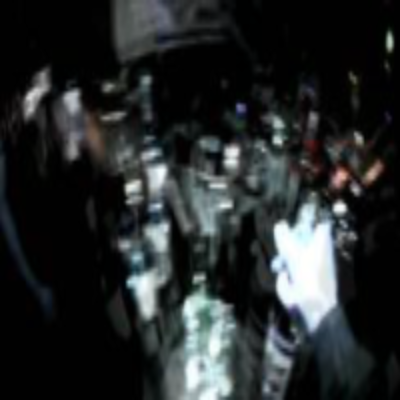

In [27]:
cv2.imshow(image.asMat, (400, 400))

In [19]:
val indices = new Mat()
val mat = loader.asMat(image)

indices: Mat = org.bytedeco.javacpp.opencv_core$Mat[width=0,height=0,depth=8,channels=1]
mat: Mat = org.bytedeco.javacpp.opencv_core$Mat[width=200,height=100,depth=32,channels=3]

In [17]:
import org.bytedeco.javacpp.opencv_core
import org.bytedeco.javacpp.opencv_core._
import org.bytedeco.javacpp.opencv_highgui
import org.bytedeco.javacpp.opencv_imgproc
import java.awt.image.BufferedImage
import java.awt.image.DataBufferByte


import org.bytedeco.javacpp.opencv_core
import org.bytedeco.javacpp.opencv_core._
import org.bytedeco.javacpp.opencv_highgui
import org.bytedeco.javacpp.opencv_imgproc
import java.awt.image.BufferedImage
import java.awt.image.DataBufferByte

In [ ]:
// Read image as before
Mat rgba = Highgui.imread(filePath);
Imgproc.cvtColor(rgba, rgba, Imgproc.COLOR_RGB2GRAY, 0);

// Create an empty image in matching format
BufferedImage gray = new BufferedImage(rgba.width(), rgba.height(), BufferedImage.TYPE_BYTE_GRAY);

// Get the BufferedImage's backing array and copy the pixels directly into it
byte[] data = ((DataBufferByte) gray.getRaster().getDataBuffer()).getData();
rgba.get(0, 0, data);

In [12]:
val rgba = loader.asMat(image )

rgba: Mat = org.bytedeco.javacpp.opencv_core$Mat[width=200,height=100,depth=32,channels=3]

In [14]:
opencv_imgproc.cvtColor(rgba, rgba, opencv_imgproc.COLOR_RGB2GRAY, 0)

In [16]:
val gray = new BufferedImage(rgba.size.width, rgba.size.height, BufferedImage.TYPE_BYTE_GRAY)

gray: BufferedImage = BufferedImage@63a6aee5: type = 10 ColorModel: #pixelBits = 8 numComponents = 1 color space = java.awt.color.ICC_ColorSpace@58a00108 transparency = 1 has alpha = false isAlphaPre = false ByteInterleavedRaster: width = 200 height = 100 #numDataElements 1 dataOff[0] = 0

In [18]:
val data = gray.getRaster().getDataBuffer().asInstanceOf[DataBufferByte].getData()

data: Array[Byte] = Array(
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
...

In [18]:
rgba.get(0, 0, data);

: 

In [18]:
def matify(im: BufferedImage) = {
    // Convert INT to BYTE
    //im = new BufferedImage(im.getWidth(), im.getHeight(),BufferedImage.TYPE_3BYTE_BGR);
    // Convert bufferedimage to byte array
    val pixels = im.getRaster().getDataBuffer().asInstanceOf[DataBufferByte].getData();

    // Create a Matrix the same size of image
    val image = new Mat(im.getHeight(), im.getWidth(), CV_8UC3);
    // Fill Matrix with image values
    image.put(0, 0, pixels);

    image;
}

: 